<a href="https://colab.research.google.com/github/Nuthan03/Tranfer_Learning-Feature-Extraction-/blob/main/Tansfer_learning_in_TF(Feature_extraction).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tansfer Learning with TensorFlow (Feature Extraction)

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problems.
There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those to our own data.

In [1]:
# Check if we are running GPU
!nvidia-smi

Wed Nov 29 03:12:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-11-29 03:12:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.172.207, 74.125.201.207, 74.125.202.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.172.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   175MB/s    in 0.9s    

2023-11-29 03:12:32 (175 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images do we have ?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

## Creating data loaders
we will use the 'ImageDataGenerator' class to load in our images in batches

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                                target_size=IMAGE_SIZE,
                                                batch_size=BATCH_SIZE,
                                                class_mode="categorical")

print("test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SIZE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
test images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks

Callbacks are extra functionality you cann add to your models to be performed during or after training. Some of the most popular callbacks :
* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [5]:
# Create a TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )

  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In [6]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-classification/versions/1"

In [7]:
# Import dependecies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [8]:
# Let's make a create_model() function to create a mdoel from URL
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SIZE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="outout_layer")
  ])

  return model

### Creating and testing ResNet Tensorflow Hub Feature Extraction model

In [9]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data.num_classes)

In [10]:
# Compile our model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [11]:
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")]
                                  )

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20231129-031248
Epoch 1/5
24/24 [==============================] - 28s 550ms/step - loss: 1.9192 - accuracy: 0.3373 - val_loss: 1.1857 - val_accuracy: 0.6344
Epoch 2/5
24/24 [==============================] - 11s 469ms/step - loss: 0.8939 - accuracy: 0.7280 - val_loss: 0.8309 - val_accuracy: 0.7328
Epoch 3/5
24/24 [==============================] - 11s 451ms/step - loss: 0.6110 - accuracy: 0.8333 - val_loss: 0.7561 - val_accuracy: 0.7620
Epoch 4/5
24/24 [==============================] - 12s 515ms/step - loss: 0.4648 - accuracy: 0.8853 - val_loss: 0.6919 - val_accuracy: 0.7768
Epoch 5/5
24/24 [==============================] - 11s 466ms/step - loss: 0.3746 - accuracy: 0.9147 - val_loss: 0.6660 - val_accuracy: 0.7756


In [12]:
# Let's create a function to plot our loss curves
import matplotlib.pyplot as plt

#Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

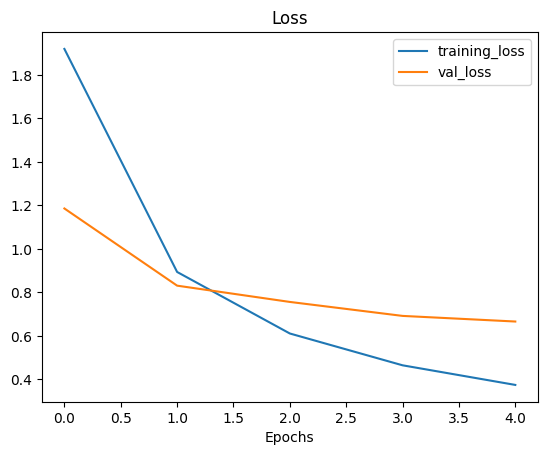

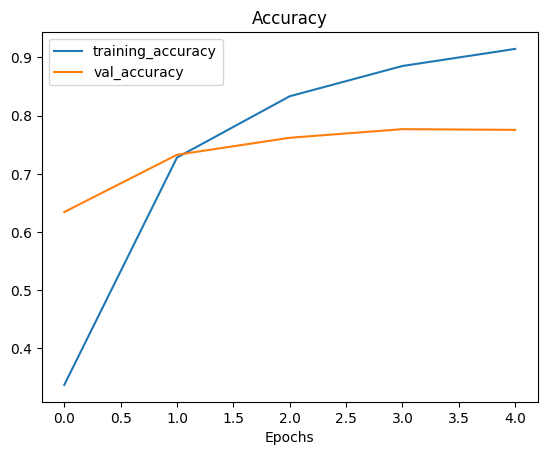

In [13]:
plot_loss_curves(resnet_history)

In [14]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 outout_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [15]:
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data.num_classes)

# Compile EfficientNet Model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=5,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20231129-031432
Epoch 1/5
24/24 [==============================] - 22s 514ms/step - loss: 2.2940 - accuracy: 0.1893 - val_loss: 2.2855 - val_accuracy: 0.2312
Epoch 2/5
24/24 [==============================] - 13s 537ms/step - loss: 2.2793 - accuracy: 0.2707 - val_loss: 2.2705 - val_accuracy: 0.3180
Epoch 3/5
24/24 [==============================] - 10s 412ms/step - loss: 2.2649 - accuracy: 0.4013 - val_loss: 2.2558 - val_accuracy: 0.4920
Epoch 4/5
24/24 [==============================] - 10s 441ms/step - loss: 2.2506 - accuracy: 0.4853 - val_loss: 2.2411 - val_accuracy: 0.5284
Epoch 5/5
24/24 [==============================] - 11s 454ms/step - loss: 2.2364 - accuracy: 0.5093 - val_loss: 2.2267 - val_accuracy: 0.5552


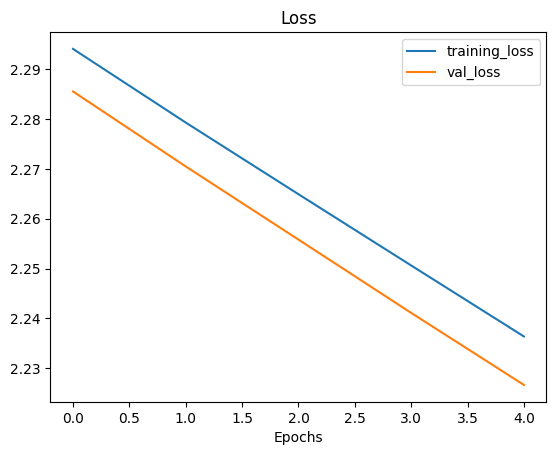

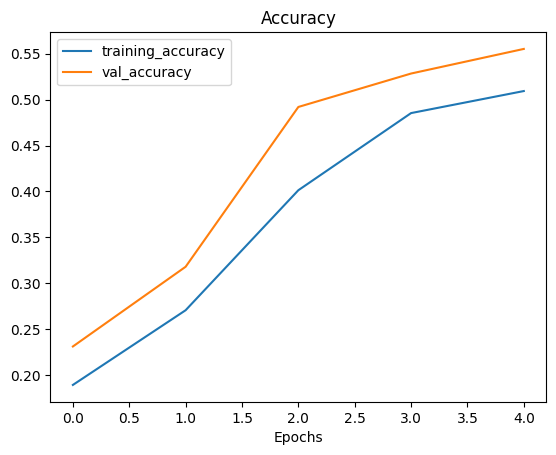

In [16]:
plot_loss_curves(efficientnet_history)

In [17]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1000)              5330564   
 KerasLayer)                                                     
                                                                 
 outout_layer (Dense)        (None, 10)                10010     
                                                                 
Total params: 5340574 (20.37 MB)
Trainable params: 10010 (39.10 KB)
Non-trainable params: 5330564 (20.33 MB)
_________________________________________________________________


### Comparing models using TensorBoard

In [18]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs ResNet50V2" \
  --description "Comparing two different TF hub feature extraction model architectures using 10% of the training data" \
  --one_shot

2023-11-29 03:15:56.248534: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 03:15:56.248606: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 03:15:56.248656: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 03:15:57.249664: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use 